##Домашние задание №4
###Выполнила: Косарева Екатерина (DS-22)

**Описание эксперимента:**
Есть мобильное приложение. В этом приложении у пользователей есть возможность покупать игровые предметы за реальные деньги. Чтобы стимулировать пользователей их покупать, приложение периодически предлагает пользователям товары - появляется окошко с рекомендацией купить товар. Отдел машинного обучения предложил улучшение для текущего алгоритма выбора рекомендации. Для проверки улучшений алгоритма был проведен A/B тест. Лог его проведения предоставлен в прикрепленном файле.

**Метрика:** средний доход от пользователя за 1 неделю после первого показа ему рекомендации на 10% (после начала A/B теста время первого показа ищется снова)

**Важная информация:**
Эксперимент начинается 2023-05-01. Данные есть до 2023-06-01 (но можно завершить раньше, если это позволит оценка длительности)
Вам сказали, что его длительность должна составить 1 месяц.
Все покупки, которые вызваны не влиянием рекомендаций, в этом логе не учитываются

**Описание данных**:

    id_product -  идентификатор продукта, который был рекомендован
    is_pay - купил ли пользователь товар
    sum_payment - размер платежа (0, если не купил)
    city - город, в котором находится пользователь
    id_user - пользователь
    timestamp - timestamp события
    date - дата события

**Задачи, которые необходимо решить:**

1. Оценить длительность теста на момент его начала. Сравнить с предложенной. Для оценки необходимо использовать данные с пред экспериментального периода. Посмотреть, есть ли выбросы в данных.

2. Построить методику расчета целевой метрики. Рассчитать целевую метрику на день окончания теста (рассчитанной в п1) для группы A и B, рассчитать эффект, p_value. Посмотреть, есть ли выбросы в данных.

3. Рассчитать метрики из п2 по дням и построить их графики.
Принять решение о результате теста - обосновать.

**Дополнительно:**
При подсчете метрик обработать выбросы в данных - описать почему их можно удалить из теста, если они удаляются. Пожалуйста, не заглядывайте в будущее по данным, если рассчитанная длительность меньше предоставленных данны

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import warnings
warnings.simplefilter("ignore")

##|Анализ данных

In [2]:
data = pd.read_csv("/content/drive/MyDrive/MADE/AB/axNSsVJtVBJbNUgD.gzip", compression='gzip')


In [ ]:
data.head()

,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date
0,1680330573,user_9903,27,NaN,Санкт-Петербург,4.0,1,2023-04-01
1,1680332652,user_6732,0,NaN,Рязань,1.0,0,2023-04-01
2,1680378039,user_4199,0,NaN,Москва,3.0,0,2023-04-01
3,1680337580,user_3606,12,NaN,Санкт-Петербург,7.0,1,2023-04-01
4,1680334389,user_9519,0,NaN,Санкт-Петербург,14.0,0,2023-04-01


In [ ]:
print("Control and test goups sizes:", data[data.group=="A"].shape, data[data.group=="B"].shape)

Control and test goups sizes: (15389, 8) (15257, 8)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56405 entries, 0 to 56404
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    56405 non-null  int64  
 1   id_user      56405 non-null  object 
 2   sum_payment  56405 non-null  int64  
 3   group        30646 non-null  object 
 4   city         56405 non-null  object 
 5   id_product   56402 non-null  float64
 6   is_pay       56405 non-null  int64  
 7   date         56405 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 3.4+ MB


In [ ]:
data.describe()

,timestamp,sum_payment,id_product,is_pay
count,5.640500e+04,56405.000000,56402.000000,56405.000000
mean,1.683684e+09,5.955022,10.477643,0.279833
std,1.450366e+06,12.986465,6.328490,0.448921
min,1.680310e+09,0.000000,0.000000,0.000000
25%,1.682478e+09,0.000000,5.000000,0.000000
50%,1.683886e+09,0.000000,10.000000,0.000000
75%,1.685130e+09,12.000000,16.000000,1.000000
max,1.685567e+09,1000.000000,21.000000,1.000000


In [3]:
data.dropna(subset=["id_product"], inplace=True)
data.describe()

,timestamp,sum_payment,id_product,is_pay
count,5.640200e+04,56402.000000,56402.000000,56402.000000
mean,1.683685e+09,5.902149,10.477643,0.279795
std,1.450370e+06,10.774763,6.328490,0.448902
min,1.680310e+09,0.000000,0.000000,0.000000
25%,1.682478e+09,0.000000,5.000000,0.000000
50%,1.683887e+09,0.000000,10.000000,0.000000
75%,1.685130e+09,12.000000,16.000000,1.000000
max,1.685567e+09,53.000000,21.000000,1.000000


##Анализ выбросов

[ 0 10 11 12 13 14 16 19 20 22 25 27 28 31 36 37 38 53]


<Axes: >

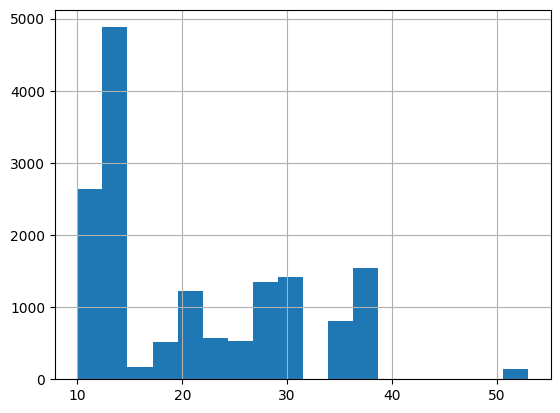

In [ ]:
print(np.unique(data.sum_payment))
data[data.sum_payment > 0].sum_payment.hist(bins=len(np.unique(data.sum_payment)))

In [ ]:
outliers = data[data.sum_payment > data.sum_payment.mean() + 3 * data.sum_payment.std()]
print("% of outliers", {outliers.shape[0] / data.shape[0]})
outliers.describe()


% of outliers {0.0025176412183965107}


,timestamp,sum_payment,id_product,is_pay
count,1.420000e+02,142.0,142.0,142.0
mean,1.683954e+09,53.0,8.0,1.0
std,1.505430e+06,0.0,0.0,0.0
min,1.680812e+09,53.0,8.0,1.0
25%,1.682560e+09,53.0,8.0,1.0
50%,1.684644e+09,53.0,8.0,1.0
75%,1.685302e+09,53.0,8.0,1.0
max,1.685565e+09,53.0,8.0,1.0


<Axes: >

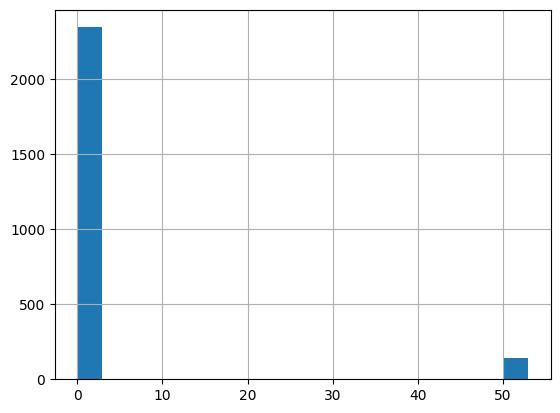

In [ ]:
data[data.id_product==8].sum_payment.hist(bins=len(np.unique(data.sum_payment)))

Unique ids of products [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21.]


<Axes: >

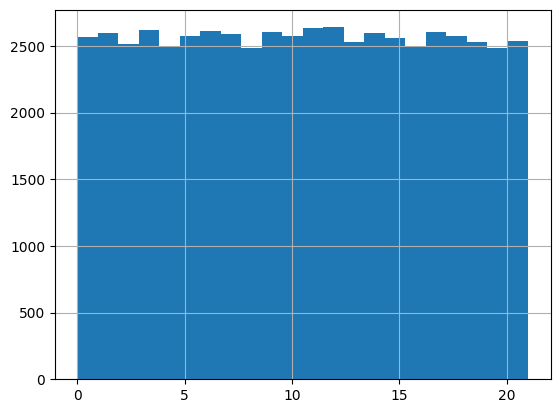

In [ ]:
print("Unique ids of products", np.unique(data.id_product))
num_product = len(np.unique(data.id_product))
data.id_product.hist(bins=num_product)

Видим, что в данных есть выбросы по полю sum_payments (всего 0,25%) и касаются только одного вида товара (id_product = 8). Мы их выбросим из данных и посмотрим как изменяться статистики

In [4]:
data_clean = data[data.sum_payment < data.sum_payment.mean() + 3 * data.sum_payment.std()]
data_clean.describe()

,timestamp,sum_payment,id_product,is_pay
count,5.626000e+04,56260.000000,56260.000000,56260.000000
mean,1.683684e+09,5.783274,10.483896,0.277977
std,1.450178e+06,10.524997,6.335246,0.448006
min,1.680310e+09,0.000000,0.000000,0.000000
25%,1.682477e+09,0.000000,5.000000,0.000000
50%,1.683885e+09,0.000000,11.000000,0.000000
75%,1.685129e+09,12.000000,16.000000,1.000000
max,1.685567e+09,38.000000,21.000000,1.000000


##Рассчитаем длительность теста.

Результаты выше показывают, что нет существенных отличий в количестве пользователей и их платежах по городам. Поэтому для тестирования мы можем брать пользователей из любого города.

Затем найдем средний платеж пользователей в неделю, и дисперсию

Зададим ошибки первого и второго рода: $α=0.05, β=0.2$.

И эффект равный 10% от дохода за неделю

Разобьем данные по периодам до 1-05-2023 и после

In [5]:
data_clean["date"] = pd.to_datetime(data_clean.date)
data_pred = data_clean[data_clean.date < datetime.strptime("2023-05-01", '%Y-%m-%d')]
data_post = data_clean[data_clean.date > datetime.strptime("2023-05-01", '%Y-%m-%d')]


In [ ]:
data_pred.head()

,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date
0,1680330573,user_9903,27,NaN,Санкт-Петербург,4.0,1,2023-04-01
1,1680332652,user_6732,0,NaN,Рязань,1.0,0,2023-04-01
2,1680378039,user_4199,0,NaN,Москва,3.0,0,2023-04-01
3,1680337580,user_3606,12,NaN,Санкт-Петербург,7.0,1,2023-04-01
4,1680334389,user_9519,0,NaN,Санкт-Петербург,14.0,0,2023-04-01


Посмотрим, как распределены пользователи и их платежи по локации

In [ ]:
city_payments = data_pred[["city", "sum_payment"]].groupby(by=["city"]).sum()
city_payments

,sum_payment
city,
Москва,28111
Рязань,39646
Санкт-Петербург,27582
Тула,13782
Ярославь,28273


In [ ]:
city_users = data_pred[["city", "id_user"]].groupby(by=["city"]).count()
city_users

,id_user
city,
Москва,5315
Рязань,7730
Санкт-Петербург,4892
Тула,2512
Ярославь,5257


Видим, что распределение пользователей и платежей по локациям достаточно однородно, поэтому будем всех пользователей использовать для рассчета времени АВ теста.

Найдем для пользователей дату первой рекомендации и рассчитаем дату окончания первой недели после нее

In [ ]:
import datetime

first_week_payment_user = data_pred[["id_user", "sum_payment", "date"]].groupby(by=["id_user"]).min()
first_week_payment_user["first_week_end"] = first_week_payment_user["date"] + datetime.timedelta(days=7)
first_week_payment_user

,sum_payment,date,first_week_end
id_user,,,
user_0,0,2023-04-13,2023-04-20
user_1,0,2023-04-30,2023-05-07
user_10,0,2023-04-27,2023-05-04
user_100,0,2023-04-17,2023-04-24
user_1000,0,2023-04-23,2023-04-30
...,...,...,...
user_9995,11,2023-04-29,2023-05-06
user_9996,0,2023-04-27,2023-05-04
user_9997,20,2023-04-30,2023-05-07


Найдем средний недельный платеж и его дисперсию

In [ ]:
week_payments = []
for user_id in first_week_payment_user.index:
  week_payments.append(data_pred[(data_pred.id_user==user_id) & (data_pred.date<=first_week_payment_user.loc[user_id].first_week_end)].sum_payment.sum())

print(f"Avrage week user payment is {np.mean(week_payments)}, week payment standard deviation {np.std(week_payments)}")

Avrage week user payment is 11.069383259911895, week payment standard deviation 16.794283232077014


Рассчитаем время AB теста. Выше мы проверили, что контрольная и тестовая группы одинакового размера.

In [ ]:
import scipy.stats as sps

def test_time(k, effect, sigma_1, sigma_2, alpha=0.05, beta=0.2):
  z = sps.norm.ppf(1 - alpha / 2) + sps.norm.ppf(1 - beta)
  n = (k + 1) * z ** 2 * (sigma_1 ** 2 + sigma_2 ** 2 / k) / (effect ** 2)
  return n

mean_payment = np.mean(week_payments)
std_payment = np.std(week_payments)
test_duration = test_time(k=1, effect=0.1 * mean_payment, sigma_1=std_payment, sigma_2=std_payment, alpha=0.05, beta=0.2)
print("Test duration: ", round(test_duration))


Test duration:  7227


Таким образом нам нужно взять выборки из 3614 пользователей, которые совершили покупку в течение недели после первой рекомендации  в каждой тестовой группе.

Для расчета целевой метрики по тестовой и контрольной выборкам за период с 1/05/2023 по 1/06/2023, сгрупируем данные по пользователям и найдем для пользователей дату первой рекомендации и рассчитаем дату окончания первой недели после нее.

После этого отберем первые по порядку 3614 дат окончания первой недели после рекомендации и узнаем сколько времени должен был проводиться тест на самом деле

In [ ]:
import datetime

first_week_payment_A = data_post[data_post.group == "A"][["id_user", "sum_payment", "date"]].groupby(by=["id_user"]).min()
first_week_payment_A["first_week_end"] = first_week_payment_A["date"] + datetime.timedelta(days=7)
print("Test end date for group A", sorted(first_week_payment_A.first_week_end)[3614])

first_week_payment_B = data_post[data_post.group == "B"][["id_user", "sum_payment", "date"]].groupby(by=["id_user"]).min()
first_week_payment_B["first_week_end"] = first_week_payment_B["date"] + datetime.timedelta(days=7)
print("Test end date for group B", sorted(first_week_payment_A.first_week_end)[3614])



Test end date for group A 2023-06-01 00:00:00
Test end date for group B 2023-06-01 00:00:00


Получаем, что тестирование должно проводиться ровно месяц до 1 июня


##2.Построить методику расчета целевой метрики.

Рассчитать целевую метрику на день окончания теста (рассчитанной в п1) для группы A и B, рассчитать эффект, p_value. Посмотреть, есть ли выбросы в данных.

Мы уже подготовили данные для теста. Найдем выборки для платежа пользователей в первую неделю после первой рекомендации

In [ ]:
first_week_payment_A["sum_payment"] = data_post[data_post.group == "A"][["id_user", "sum_payment"]].groupby(by=["id_user"]).sum()

first_week_payment_B["sum_payment"] = data_post[data_post.group == "B"][["id_user", "sum_payment"]].groupby(by=["id_user"]).sum()



In [ ]:
x_a = list(first_week_payment_A.sum_payment.iloc[:3614])
x_b = list(first_week_payment_B.sum_payment.iloc[:3614])

efect = (np.mean(x_b) - np.mean(x_a)) / np.mean(x_a)
p_value = sps.ttest_ind(x_a, x_b, equal_var=True).pvalue
print(f"Effect value: {efect}, p-value:{p_value}")


Effect value: 0.07928234390431253, p-value:0.01822035501077125


Получили средний эффект 8%, хотя хотели получить 10%.

p-value = 0,018 < 0.05, поэтому можем сказать, что изменения в системе рекоммендаций дают значимый эффект на уровне 8% повышения выручки от пользователей в первую неделю от просмотра новых рекомендаций.

Проверим наличие выбросов:

In [ ]:
df_a = pd.Series(x_a)
print("Number of outliers is ", df_a[df_a > df_a.mean() + 3* df_a.std()].shape[0])
df_a.describe()

Number of outliers is  61


count    3614.000000
mean       15.129496
std        20.688237
min         0.000000
25%         0.000000
50%        11.000000
75%        26.000000
max       203.000000
dtype: float64

<Axes: >

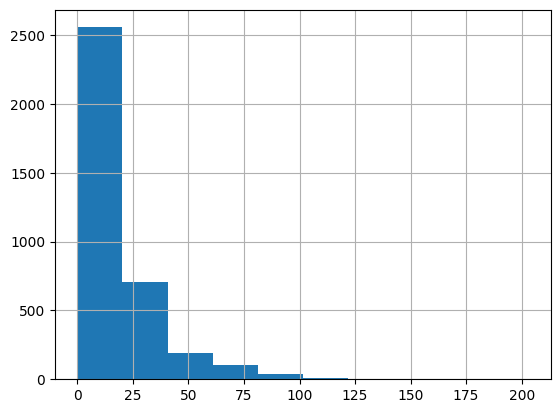

In [ ]:
pd.Series(x_a).hist()

In [ ]:
df_b = pd.Series(x_b)
print("Number of outliers is ", df_b[df_b > df_b.mean() + 3* df_b.std()].shape[0])
df_b.describe()

Number of outliers is  60


count    3614.000000
mean       16.328998
std        22.456772
min         0.000000
25%         0.000000
50%        11.000000
75%        28.000000
max       218.000000
dtype: float64

<Axes: >

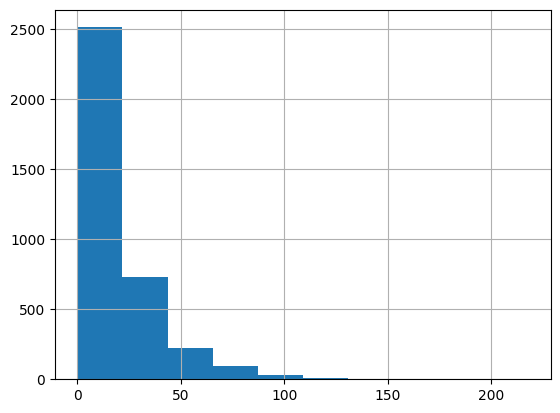

In [ ]:
pd.Series(x_b).hist()


Видим, что в обеих группах присутствует небольшое число выбросов.

Проверим критерий для данных без выбросов:

In [ ]:
A_payments_no_outliers = first_week_payment_A[first_week_payment_A.sum_payment < first_week_payment_A.sum_payment.mean() + 3 * first_week_payment_A.sum_payment.std()]
B_payments_no_outliers = first_week_payment_B[first_week_payment_B.sum_payment < first_week_payment_B.sum_payment.mean() + 3 * first_week_payment_B.sum_payment.std()]

test_size = min(3614, A_payments_no_outliers.shape[0], B_payments_no_outliers.shape[0])
print("Test size =", test_size)

x_a = list(A_payments_no_outliers.sum_payment.iloc[:test_size])
x_b = list(B_payments_no_outliers.sum_payment.iloc[:test_size])

efect = (np.mean(x_b) - np.mean(x_a)) / np.mean(x_a)
p_value = sps.ttest_ind(x_a, x_b, equal_var=True).pvalue
print(f"Effect value: {efect}, p-value:{p_value}")


Test size = 3614
Effect value: 0.06891237340378695, p-value:0.027189777610599652


Эффект уменьшился, но достоверность осталась примерно на том же уровне. Поэтому гипотеза о том, что новые рекомендации дают эффект принимается.

##3. Рассчитать метрики из п2 по дням и построить их графики. Принять решение о результате теста - обосновать.


In [ ]:
days = pd.date_range(start='5/1/2023', end='6/1/2023')
avr_payments_A = []
avr_payments_B = []

p_val = []
for i in range(days.shape[0]):
  payments_by_day_A = A_payments_no_outliers[A_payments_no_outliers.date < days[i]]
  payments_by_day_B = B_payments_no_outliers[B_payments_no_outliers.date < days[i]]

  avr_payments_A.append(payments_by_day_A.sum_payment.sum() / payments_by_day_A.shape[0])
  avr_payments_B.append(payments_by_day_B.sum_payment.sum() / payments_by_day_B.shape[0])

  p_val.append(sps.ttest_ind(list(payments_by_day_A.sum_payment), list(payments_by_day_B.sum_payment), equal_var=True).pvalue)



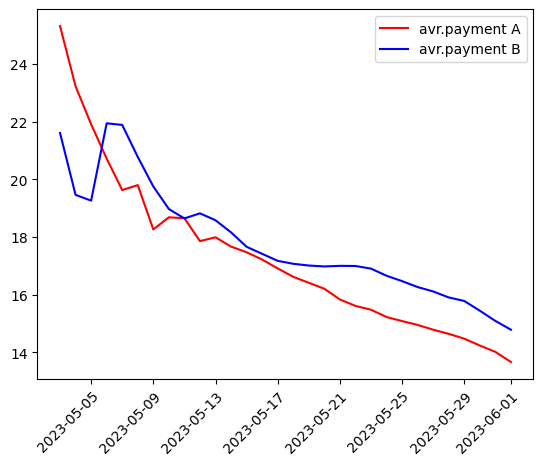

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

plt.plot(days, avr_payments_A, c = "r", label="avr.payment A")
plt.plot(days, avr_payments_B, c= "b", label="avr.payment B")
plt.legend()
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.show()

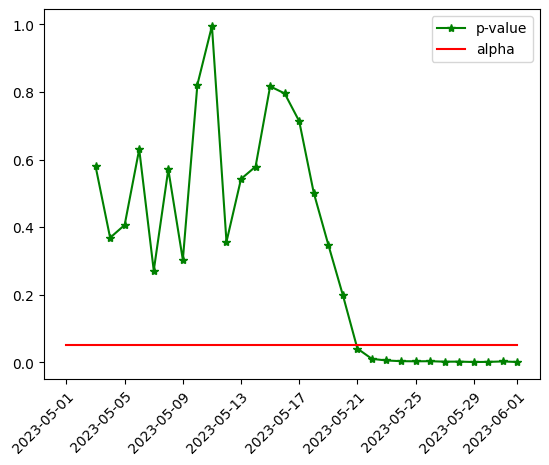

In [ ]:
alpha = [0.05 for _ in range(days.shape[0])]
fig, ax = plt.subplots()

plt.plot(days, p_val, c = "green", marker="*", label="p-value")
plt.plot(days, alpha, c="r", label="alpha")
plt.legend()
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.show()

Как видно из графиков средние платежи пользователей действительно выросли по сравнению с контрольной группой. А значение p-value к концу периода тестирования стало меньше заданного уровня значимости 0,05.

##Выводы:
Новые рекомендации увеличивают целевую метрику, о чем свидетельствует t статистика, поэтому их можно внедрять в продакшн.


#ПОДХОД №2

Рассчитаем число пользователей,

In [6]:
import datetime

first_week_payment_user = data_pred[["id_user", "sum_payment", "date"]].groupby(by=["id_user"]).min()
first_week_payment_user["first_week_end"] = first_week_payment_user["date"] + datetime.timedelta(days=7)
first_week_payment_user

,sum_payment,date,first_week_end
id_user,,,
user_0,0,2023-04-13,2023-04-20
user_1,0,2023-04-30,2023-05-07
user_10,0,2023-04-27,2023-05-04
user_100,0,2023-04-17,2023-04-24
user_1000,0,2023-04-23,2023-04-30
...,...,...,...
user_9995,11,2023-04-29,2023-05-06
user_9996,0,2023-04-27,2023-05-04
user_9997,20,2023-04-30,2023-05-07


Найдем средний недельный платеж и его дисперсию

In [7]:
week_payments = []
for user_id in first_week_payment_user.index:
  week_payments.append(data_pred[(data_pred.id_user==user_id) & (data_pred.date<=first_week_payment_user.loc[user_id].first_week_end)].sum_payment.sum())

print(f"Avrage week user payment is {np.mean(week_payments)}, week payment standard deviation {np.std(week_payments)}")

Avrage week user payment is 11.069383259911895, week payment standard deviation 16.794283232077014


Рассчитаем время AB теста. Выше мы проверили, что контрольная и тестовая группы одинакового размера.

In [8]:
import scipy.stats as sps

def test_time(k, effect, sigma_1, sigma_2, alpha=0.05, beta=0.2):
  z = sps.norm.ppf(1 - alpha / 2) + sps.norm.ppf(1 - beta)
  n = (k + 1) * z ** 2 * (sigma_1 ** 2 + sigma_2 ** 2 / k) / (effect ** 2)
  return n

mean_payment = np.mean(week_payments)
std_payment = np.std(week_payments)
test_duration = test_time(k=1, effect=0.1 * mean_payment, sigma_1=std_payment, sigma_2=std_payment, alpha=0.05, beta=0.2)
print("Test duration: ", round(test_duration))


Test duration:  7227


Таким образом нам нужно взять выборки из 3614 пользователей, которые совершили покупку в течение недели после первой рекомендации  в каждой тестовой группе.

Для расчета целевой метрики по тестовой и контрольной выборкам за период с 1/05/2023 по 1/06/2023, сгрупируем данные по пользователям и найдем для пользователей дату первой рекомендации и рассчитаем дату окончания первой недели после нее.

После этого отберем первые по порядку 3614 дат окончания первой недели после рекомендации и узнаем сколько времени должен был проводиться тест на самом деле

In [9]:
import datetime

first_week_payment_A = data_post[data_post.group == "A"][["id_user", "sum_payment", "date"]].groupby(by=["id_user"]).min()
first_week_payment_A["first_week_end"] = first_week_payment_A["date"] + datetime.timedelta(days=7)
print("Test end date for group A", sorted(first_week_payment_A.first_week_end)[3614])

first_week_payment_B = data_post[data_post.group == "B"][["id_user", "sum_payment", "date"]].groupby(by=["id_user"]).min()
first_week_payment_B["first_week_end"] = first_week_payment_B["date"] + datetime.timedelta(days=7)
print("Test end date for group B", sorted(first_week_payment_A.first_week_end)[3614])



Test end date for group A 2023-06-01 00:00:00
Test end date for group B 2023-06-01 00:00:00


Получаем, что тестирование должно проводиться ровно месяц до 1 июня


##2.Построить методику расчета целевой метрики.

Рассчитать целевую метрику на день окончания теста (рассчитанной в п1) для группы A и B, рассчитать эффект, p_value. Посмотреть, есть ли выбросы в данных.

Мы уже подготовили данные для теста. Найдем выборки для платежа пользователей в первую неделю после первой рекомендации

In [27]:
one_week_payments_A = []
for user in first_week_payment_A.index:
  df = data_post[(data_post.group == "A")&(data_post.id_user == user)&(data_post.date < first_week_payment_A.loc[user]["first_week_end"])]
  one_week_payments_A.append(df.sum_payment.sum())



In [28]:
one_week_payments_B = []
for user in first_week_payment_B.index:
  df = data_post[(data_post.group == "B")&(data_post.id_user == user)&(data_post.date < first_week_payment_B.loc[user]["first_week_end"])]
  one_week_payments_B.append(df.sum_payment.sum())


In [30]:
control_payments_A = pd.DataFrame(columns=["id_user", "sum_payment"])
test_payments_B = pd.DataFrame(columns=["id_user", "sum_payment"])
control_payments_A["id_user"] = first_week_payment_A.index
control_payments_A["sum_payment"] = one_week_payments_A
test_payments_B["id_user"] = first_week_payment_B.index
test_payments_B["sum_payment"] = one_week_payments_B

In [34]:
x_a = list(control_payments_A.sum_payment.iloc[:3614])
x_b = list(test_payments_B.sum_payment.iloc[:3614])

efect = (np.mean(x_b) - np.mean(x_a)) / np.mean(x_a)
p_value = sps.ttest_ind(x_a, x_b, equal_var=True).pvalue
print(f"Effect value: {efect}, p-value:{p_value}")


Effect value: 0.06683249636269772, p-value:0.05960215969429357


Получили средний эффект 7%, хотя хотели получить 10%.

p-value = 0,06 > 0.05, поэтому можем сказать, что изменения в системе рекоммендаций не дают значимый эффект выручки от пользователей в первую неделю от просмотра новых рекомендаций.

Проверим наличие выбросов:

In [35]:
df_a = pd.Series(x_a)
print("Number of outliers is ", df_a[df_a > df_a.mean() + 3* df_a.std()].shape[0])
df_a.describe()

Number of outliers is  67


count    3614.000000
mean       11.791367
std        17.586123
min         0.000000
25%         0.000000
50%         0.000000
75%        20.000000
max       133.000000
dtype: float64

<Axes: >

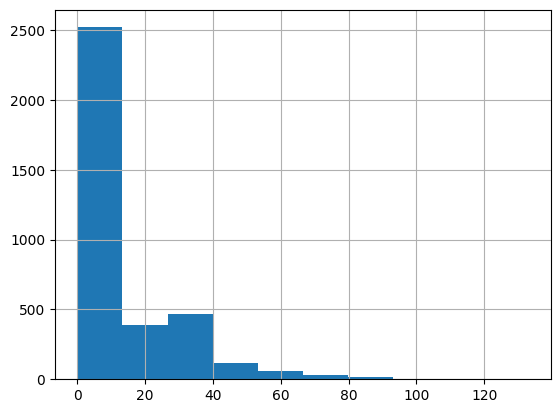

In [36]:
pd.Series(x_a).hist()

In [37]:
df_b = pd.Series(x_b)
print("Number of outliers is ", df_b[df_b > df_b.mean() + 3* df_b.std()].shape[0])
df_b.describe()

Number of outliers is  58


count    3614.000000
mean       12.579413
std        17.972861
min         0.000000
25%         0.000000
50%         0.000000
75%        20.000000
max       178.000000
dtype: float64

<Axes: >

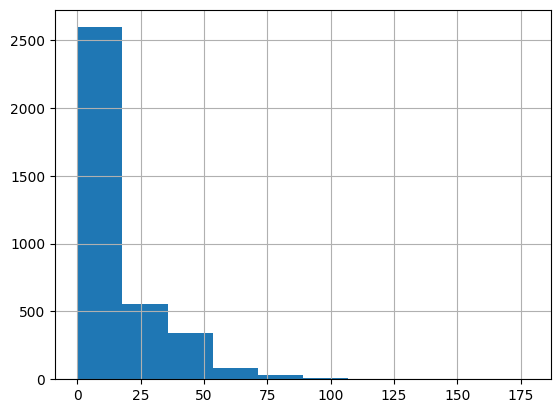

In [38]:
pd.Series(x_b).hist()


Видим, что в обеих группах присутствует небольшое число выбросов.

Проверим критерий для данных без выбросов:

In [39]:
A_payments_no_outliers = control_payments_A[control_payments_A.sum_payment < control_payments_A.sum_payment.mean() + 3 * control_payments_A.sum_payment.std()]
B_payments_no_outliers = test_payments_B[test_payments_B.sum_payment < test_payments_B.sum_payment.mean() + 3 * test_payments_B.sum_payment.std()]

test_size = min(3614, A_payments_no_outliers.shape[0], B_payments_no_outliers.shape[0])
print("Test size =", test_size)

x_a = list(A_payments_no_outliers.sum_payment.iloc[:test_size])
x_b = list(B_payments_no_outliers.sum_payment.iloc[:test_size])

efect = (np.mean(x_b) - np.mean(x_a)) / np.mean(x_a)
p_value = sps.ttest_ind(x_a, x_b, equal_var=True).pvalue
print(f"Effect value: {efect}, p-value:{p_value}")


Test size = 3614
Effect value: 0.09199157007376185, p-value:0.006749903592168939


Эффект увеличился и p-value стал меньше 0,05. Поэтому после удаления выбросов гипотеза о том, что новые рекомендации дают эффект может приниматься.

##3. Рассчитать метрики из п2 по дням и построить их графики. Принять решение о результате теста - обосновать.


In [51]:
payments_during_week_A = pd.DataFrame(columns = data_post.columns.values)

for user in first_week_payment_A.index:
  df = data_post[(data_post.group == "A")&(data_post.id_user == user)&(data_post.date < first_week_payment_A.loc[user]["first_week_end"])]
  payments_during_week_A = payments_during_week_A.append(df)



In [52]:
payments_during_week_B = pd.DataFrame(columns = data_post.columns.values)

for user in first_week_payment_B.index:
  df = data_post[(data_post.group == "B")&(data_post.id_user == user)&(data_post.date < first_week_payment_B.loc[user]["first_week_end"])]
  payments_during_week_B = payments_during_week_B.append(df)


In [54]:
payments_during_week_A_no_outliers = payments_during_week_A[payments_during_week_A.sum_payment < payments_during_week_A.sum_payment.mean() + 3* payments_during_week_A.sum_payment.std()]
payments_during_week_B_no_outliers = payments_during_week_B[payments_during_week_B.sum_payment < payments_during_week_B.sum_payment.mean() + 3* payments_during_week_B.sum_payment.std()]

In [57]:
days = pd.date_range(start='5/1/2023', end='6/1/2023')
avr_payments_A = []
avr_payments_B = []

p_val = []
for i in range(days.shape[0]):
  payments_by_day_A = payments_during_week_A_no_outliers[payments_during_week_A_no_outliers.date < days[i]]
  payments_by_day_B = payments_during_week_B_no_outliers[payments_during_week_B_no_outliers.date < days[i]]

  if payments_by_day_A.shape[0] > 0:
    avr_payments_A.append(payments_by_day_A.sum_payment.sum() / payments_by_day_A.shape[0])
  else:
    avr_payments_A.append(0)
  if payments_by_day_B.shape[0] > 0:
    avr_payments_B.append(payments_by_day_B.sum_payment.sum() / payments_by_day_B.shape[0])
  else:
    avr_payments_B.append(0)

  p_val.append(sps.ttest_ind(list(payments_by_day_A.sum_payment), list(payments_by_day_B.sum_payment), equal_var=True).pvalue)



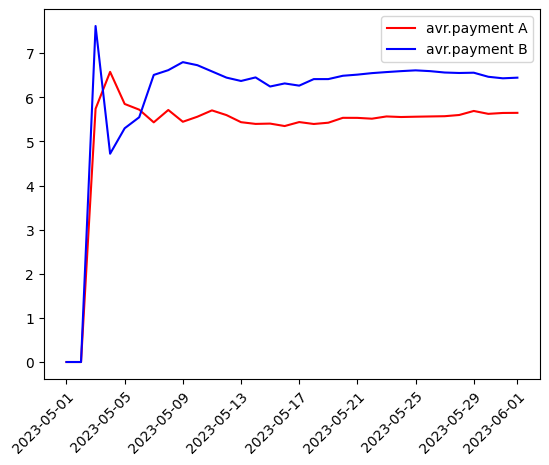

In [58]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

plt.plot(days, avr_payments_A, c = "r", label="avr.payment A")
plt.plot(days, avr_payments_B, c= "b", label="avr.payment B")
plt.legend()
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.show()

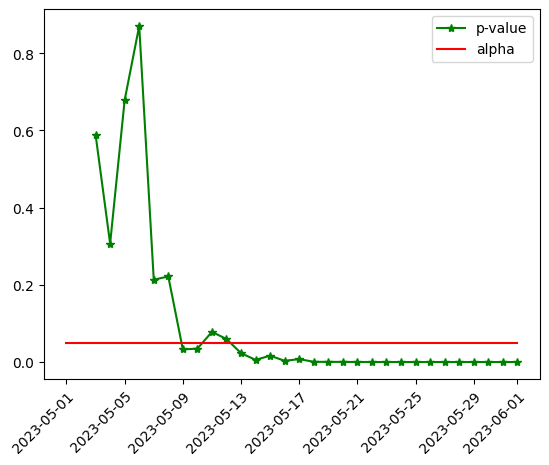

In [59]:
alpha = [0.05 for _ in range(days.shape[0])]
fig, ax = plt.subplots()

plt.plot(days, p_val, c = "green", marker="*", label="p-value")
plt.plot(days, alpha, c="r", label="alpha")
plt.legend()
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.show()

Как видно из графиков средние платежи пользователей действительно выросли по сравнению с контрольной группой. А значение p-value к концу периода тестирования стало меньше заданного уровня значимости 0,05.

##Выводы:
Новые рекомендации увеличивают целевую метрику, о чем свидетельствует t статистика, поэтому их можно внедрять в продакшн.
